## 阿尔兹海默症诊断场景下对3D-VGGNet转化为脉冲神经网络SNN的性能测试
本程序包括以下两部分内容：
1. 构建之前用到的3D-VGGNET、数据集相关的函数；
2. 使用Braincog将3D-VGGNet拆分成特征提取器和分类器，只将其中的分类器转化为脉冲神经网络，继而将两个网络部分重新组合并测试转化为SNN并测试性能；

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import string
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from einops import rearrange,repeat
from torch.utils.data import TensorDataset
from collections import Counter
from torchinfo import summary
import gc
from d2l import torch as d2l
import npx
import math
from scipy.ndimage import rotate  # 用于数据增强的旋转
import copy
import os
from glob import glob
import nibabel as nib              # 医学MRI数据处理
import sys
#np.set_printoptions(threshold=np.inf)

In [2]:
gc.collect()
torch.cuda.empty_cache()

### 2.1 数据增强函数

In [3]:
# 按照指定轴进行数据增强
class RandomRotate_fixaxis:
    """
    Rotate an array by a random degrees from taken from (-angle_spectrum, angle_spectrum) interval.
    Rotation axis is picked at random from the list of provided axes.（定轴）
    """

    def __init__(self, random_state, angle_spectrum=10, axes=None, mode='reflect', order=0, **kwargs):
        if axes is None:
            axes = [(1, 0), (2, 1), (2, 0)]   # 转轴待选择集合(其实就表示三维空间的三个轴)
        else:
            assert isinstance(axes, list) and len(axes) > 0

        self.random_state = random_state
        self.angle_spectrum = angle_spectrum
        self.axes = axes
        self.mode = mode
        self.order = order

    def __call__(self, m):
        # 从提供的转动轴中随机选一个旋转
        # axis = self.axes[self.random_state.randint(len(self.axes))]

        # 也可以选择指定轴进行旋转
        axis = self.axes[2]

        # 随机生成转角
        angle = self.random_state.randint(-self.angle_spectrum, self.angle_spectrum)
        # print(angle)
        if m.ndim == 3:
            m = rotate(m, angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1)
        else:
            channels = [rotate(m[c], angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1) for c
                        in range(m.shape[0])]
            m = np.stack(channels, axis=0)

        return m,angle

In [4]:
class RandomRotate:
    """
    Rotate an array by a random degrees from taken from (-angle_spectrum, angle_spectrum) interval.
    Rotation axis is picked at random from the list of provided axes.
    """

    def __init__(self, random_state, angle_spectrum=30, axes=None, mode='reflect', order=0, **kwargs):
        if axes is None:
            axes = [(1, 0), (2, 1), (2, 0)]   # 转轴待选择集合(其实就表示三维空间的三个轴)
        else:
            assert isinstance(axes, list) and len(axes) > 0

        self.random_state = random_state
        self.angle_spectrum = angle_spectrum
        self.axes = axes
        self.mode = mode
        self.order = order

    def __call__(self, m):
        # 从提供的转动轴中随机选一个旋转
        axis = self.axes[self.random_state.randint(len(self.axes))]

        # 也可以选择指定轴进行旋转
        # axis = self.axes[2]

        # 随机生成(整数)转角
        angle = self.random_state.randint(-self.angle_spectrum, self.angle_spectrum)
        # print(angle)
        if m.ndim == 3:
            m = rotate(m, angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1)
        else:
            channels = [rotate(m[c], angle, axes=axis, reshape=False, order=self.order, mode=self.mode, cval=-1) for c
                        in range(m.shape[0])]
            m = np.stack(channels, axis=0)

        return m

In [5]:
# 对比度数据增强_仅用于绘图
class RandomContrast_test:
    """
    Adjust contrast by scaling each voxel to `mean + alpha * (v - mean)`.
    """

    def __init__(self, random_state, alpha=(0.8, 1.2), execution_probability=1, **kwargs):   # execution_probability表示调整的概率
        self.random_state = random_state
        assert len(alpha) == 2
        self.alpha = alpha
        self.execution_probability = execution_probability

    def __call__(self, m):
        if self.random_state.uniform() < self.execution_probability:
            alpha = self.random_state.uniform(self.alpha[0], self.alpha[1])
            m = m.astype('float')  # 先把uint转化为float防止爆范围
            #alphaa = 1
            mean = np.mean(m[m!=0])  # 计算图片非0部分的均值
            #print(mean)
            result = np.copy(m)
            result[result!=0] = mean + alpha * (result[result!=0] - mean) # 图片非0部分的对比度改变
            # print(result)
            result = np.rint(np.clip(result,0,255)).astype('uint8')  # 计算之后通过clip限制范围，再返回uint
            #print(result)
            # result = self.mean + alpha * (m - self.mean)
            # print(alpha)
            # print(mean,np.max(m),np.min(result),np.max(result))
            #print(m.dtype,result.dtype)
            return result,alpha

In [6]:
# 对比度数据增强_正式（区别就在于有无返回alpha）
class RandomContrast:
    """
    Adjust contrast by scaling each voxel to `mean + alpha * (v - mean)`.
    """

    def __init__(self, random_state, alpha=(0.8, 1.2), execution_probability=1, **kwargs):   # execution_probability表示调整的概率
        self.random_state = random_state
        assert len(alpha) == 2
        self.alpha = alpha
        self.execution_probability = execution_probability

    def __call__(self, m):
        if self.random_state.uniform() < self.execution_probability:
            alpha = self.random_state.uniform(self.alpha[0], self.alpha[1])
            m = m.astype('float')  # 先把uint转化为float防止爆范围
            #alphaa = 1
            mean = np.mean(m[m!=0])  # 计算图片非0部分的均值
            #print(mean)
            result = np.copy(m)
            result[result!=0] = mean + alpha * (result[result!=0] - mean) # 图片非0部分的对比度改变
            # print(result)
            result = np.rint(np.clip(result,0,255)).astype('uint8')  # 计算之后通过clip限制范围，再返回uint
            #print(result)
            # result = self.mean + alpha * (m - self.mean)
            # print(alpha)
            # print(mean,np.max(m),np.min(result),np.max(result))
            #print(m.dtype,result.dtype)
            return result

### 2.2 构建Dataset类

In [7]:
# 测试集数据直接构造即可
class MyDataset(Dataset):
    def __init__(self, x,y):
        self.data = x
        self.label = y

    def __getitem__(self, index):
        img = self.data[index]
        img_label = self.label[index]
        return img, img_label

    def __len__(self):
        return len(self.label)
    
    def plotall(self):
        '''  展示不同对象相同位置的图片  
             输入：无
             输出：无(直接绘图)''' 
        rows = 3 # 行
        cols = 3 # 列
        fig = plt.figure(figsize=(5*cols, 5*rows)) # 画布大小   # 绘制多子图
        for i in range(rows*cols):     
            fig.add_subplot(rows, cols, i+1) 
            plt.imshow(np.rot90(self.data[30*i,:,:,:,:].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])[:,100,:],1), cmap='gray') # 显示数字
            plt.title("ID: "+str(30*i), y=-0.16) # 显示对应的标签
        plt.show()

    def plotimg(self , patient_id):
        '''  展示同一对象不同深度的纵切面  
             输入：图像标签idx
             输出：无(直接绘图)''' 
        rows = 3 # 行
        cols = 3 # 列
        fig = plt.figure(figsize=(5*cols, 5*rows)) # 画布大小   # 绘制多子图
        for i in range(rows*cols):     
            fig.add_subplot(rows, cols, i+1) 
            plt.imshow(np.rot90(self.data[patient_id,:,:,:,:].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])[:,(self.data.shape[3]//9)*i,:],1), cmap='gray') # 显示数字
            plt.title("DEEP: "+str((self.data.shape[2]//9)*i)+"", y=-0.16) # 显示对应的标签
        plt.show()
        
    def normalize(self):
        '''  完成MRI图像的标准化  
             输入：无
             输出：无()''' 
        # 对x进行数据转化和标准化
        self.data = self.data.astype('float32')
        self.data = self.data/255
        print("归一化后的MRI图像数值范围，形状和数据类型：")
        print(np.min(self.data),np.max(self.data),self.data.shape,self.data.dtype)

    def aug_rotate(self,aug_num = 2):
        '''  MRI图像的数据增强，通过旋转让数据集翻倍  
             输入：aug_num-数据增强的倍数
             输出：无()''' 
        # 读取数据集大小
        length = len(self.label)
        # 设置旋转转换器
        t = RandomRotate(np.random.RandomState(), angle_spectrum=3)

        # 为避免多次大规模数组拼接，设置中介值用于短暂储存增强后的数据，每存100次归零1次
        imgset_aftaug = [] 
        # labelset_aftaug = torch.tensor([])
        
        print('数据增强开始，此时的数据集大小为：')
        print(self.data.shape)

        # 遍历j次
        for j in range(aug_num):
            # 每次遍历将每个图像翻倍一次
            for i in range(length):

                # 进行随机的旋转并复制原始图像标签
                img_aftaug = t(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])).reshape(1,1,self.data.shape[2],self.data.shape[3],self.data.shape[4])
                # label_aftaug = self.label[i]

                if i == 0:  # 每轮开始时献给存储数组赋值
                    print('轮次开始：')
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                elif i % 50 == 0:
                    print('数据增强50数据完成，此时的数据集大小为：')
                    # print(imgset_aftaug.shape)
                    # print(label_aftaug)
                    self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
                    print(self.data.shape)
                    # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
                    # 重新赋值数组，进行拼接
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                else:
                    imgset_aftaug = np.concatenate((imgset_aftaug,img_aftaug),axis=0)
                    # labelset_aftaug = np.concatenate((labelset_aftaug,label_aftaug),axis=0)
                
            # 完成一轮后把多出来的拼接上
            self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
            # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
            # 归零
            imgset_aftaug = [] 
            # labelset_aftaug = []

            print('完成 %d 轮数据增强时的数据集大小为：'%(j+1))
            print(self.data.shape)
        
        self.label = repeat(self.label,'h -> (repeat h)', repeat=aug_num+1 )
        print('数据增强后的数据集大小为：')
        print(self.data.shape)
        print('数据增强后的标签数量为：')
        print(self.label.shape)

    def aug_contract(self,aug_num = 2):
        '''  MRI图像的数据增强，通过旋转让数据集翻倍  
             输入：aug_num-数据增强的倍数
             输出：无()''' 
        # 读取数据集大小
        length = len(self.label)
        # 设置旋转转换器
        t = RandomContrast(np.random.RandomState(), alpha=(0.85, 1.15))

        # 为避免多次大规模数组拼接，设置中介值用于短暂储存增强后的数据，每存100次归零1次
        imgset_aftaug = [] 
        # labelset_aftaug = torch.tensor([])
        
        print('数据增强开始，此时的数据集大小为：')
        print(self.data.shape)

        # 遍历j次
        for j in range(aug_num):
            # 每次遍历将每个图像翻倍一次
            for i in range(length):

                # 进行对比度调整并复制原始图像标签
                img_aftaug = t(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])).reshape(1,1,self.data.shape[2],self.data.shape[3],self.data.shape[4])
                # label_aftaug = self.label[i]

                if i == 0:  # 每轮开始时献给存储数组赋值
                    print('轮次开始：')
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                elif i % 50 == 0:
                    print('数据增强50数据完成，此时的数据集大小为：')
                    # print(imgset_aftaug.shape)
                    # print(label_aftaug)
                    self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
                    print(self.data.shape)
                    # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
                    # 重新赋值数组，进行拼接
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                else:
                    imgset_aftaug = np.concatenate((imgset_aftaug,img_aftaug),axis=0)
                    # labelset_aftaug = np.concatenate((labelset_aftaug,label_aftaug),axis=0)
                
            # 完成一轮后把多出来的拼接上
            self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
            # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
            # 归零
            imgset_aftaug = [] 
            # labelset_aftaug = []

            print('完成 %d 轮数据增强时的数据集大小为：'%(j+1))
            print(self.data.shape)
        
        self.label = repeat(self.label,'h -> (repeat h)', repeat=aug_num+1 )
        print('数据增强后的数据集大小为：')
        print(self.data.shape)
        print('数据增强后的标签数量为：')
        print(self.label.shape)

    def aug_both(self,aug_num = 2):
        '''  MRI图像的数据增强，通过旋转让数据集翻倍  
             输入：aug_num-数据增强的倍数
             输出：无()''' 
        # 读取数据集大小
        length = len(self.label)
        # 设置两个数据增强器
        t1 = RandomRotate(np.random.RandomState(), angle_spectrum=3)
        t2 = RandomContrast(np.random.RandomState(), alpha=(0.85, 1.15))

        # 为避免多次大规模数组拼接，设置中介值用于短暂储存增强后的数据，每存100次归零1次
        imgset_aftaug = [] 
        # labelset_aftaug = torch.tensor([])
        
        print('数据增强开始，此时的数据集大小为：')
        print(self.data.shape)

        # 遍历j次
        for j in range(2*aug_num):
            # 每次遍历将每个图像翻倍一次
            for i in range(length):

                # 进行对比度调整并复制原始图像标签
                # print('原始范围：',np.min(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])),np.max(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4])))
                img_aftaug = t1(self.data[i].reshape(self.data.shape[2],self.data.shape[3],self.data.shape[4]))
                img_aftaug = t2(img_aftaug).reshape(1,1,self.data.shape[2],self.data.shape[3],self.data.shape[4])
                # label_aftaug = self.label[i]
                # print(img_aftaug.dtype)
                # print('调整后：',np.min(img_aftaug),np.max(img_aftaug))
                if i == 0:  # 每轮开始时献给存储数组赋值
                    print('轮次开始：')
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                elif i % 50 == 0:
                    print('数据增强50数据完成，此时的数据集大小为：')
                    # print(imgset_aftaug.shape)
                    # print(label_aftaug)
                    self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
                    print(self.data.shape)
                    # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
                    # 重新赋值数组，进行拼接
                    imgset_aftaug = img_aftaug
                    # labelset_aftaug = label_aftaug
                else:
                    imgset_aftaug = np.concatenate((imgset_aftaug,img_aftaug),axis=0)
                    # labelset_aftaug = np.concatenate((labelset_aftaug,label_aftaug),axis=0)
                
            # 完成一轮后把多出来的拼接上
            self.data = np.concatenate((self.data,imgset_aftaug),axis=0)
            # self.label = np.concatenate((self.label,labelset_aftaug),axis=0)
            # 归零
            imgset_aftaug = [] 
            # labelset_aftaug = []

            print('完成 %d 轮数据增强时的数据集大小为：'%(j+1))
            print(self.data.shape)
        
        self.label = repeat(self.label,'h -> (repeat h)', repeat=aug_num*2+1 )
        print('数据增强后的数据集大小为：')
        print(self.data.shape)
        print('数据增强后的标签数量为：')
        print(self.label.shape)

    def shuffle(self):
        '''  随机打乱数据集  
             输入：无
             输出：无()''' 
        # 构造随机数数组
        # np.random.seed(888)   # 设置随机数种子
        random_array = np.random.permutation(len(self.label))
        print(random_array)
        # random_array
        # 打乱数据集
        self.data = self.data[random_array,:,:,:,:]
        self.label = self.label[random_array]
        print("打乱后的数据集尺寸：")
        print(self.data.shape,self.data.dtype)
        print("打乱后的标签集尺寸：")
        print(self.label.shape,self.label.dtype)  

    def clear(self):
        '''  释放数据集内存  
             输入：无
             输出：无()'''
        self.data = None
        self.label = None
   

### 2.3 构建网络架构

- 初步采用三维AlexNet架构

#### 2.3.1 3D-AlexNet架构

In [8]:
# 构造二维AlexNet网络结构
net_2d = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10))

In [9]:
# 更新成三维AlexNet
net_3d = nn.Sequential(
    nn.Conv3d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2),
    nn.Conv3d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2),
    nn.Conv3d(256, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2),
    nn.Conv3d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv3d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv3d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(4096, 2))

#### 2.3.2 3D-VGGNet架构

In [10]:
# 试一试tensorflow的网络
VGGNet_3D = nn.Sequential(
    # 组1
    nn.Conv3d(1 , 32, kernel_size=9,stride=3),  nn.BatchNorm3d(32), nn.ReLU(True),
    nn.Conv3d(32, 32, kernel_size=3,padding=1),  nn.BatchNorm3d(32), nn.ReLU(True),
    nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(64),
    # 组2
    nn.Conv3d(32, 64, kernel_size=3),  nn.BatchNorm3d(64), nn.ReLU(True),
    nn.Conv3d(64, 64, kernel_size=3),  nn.BatchNorm3d(64), nn.ReLU(True),
    nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(128),
    # 组3
    nn.Conv3d(64,128, kernel_size=3),  nn.BatchNorm3d(128), nn.ReLU(True),
    nn.Conv3d(128,128, kernel_size=3),  nn.BatchNorm3d(128), nn.ReLU(True),
    nn.Conv3d(128,128, kernel_size=3),  nn.BatchNorm3d(128), nn.ReLU(True),
    nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(256),
    # 组4
 #   nn.Conv3d(64,128, kernel_size=3), nn.ReLU(),
 #   nn.Conv3d(128,128, kernel_size=3), nn.ReLU(),
 #   nn.Conv3d(128,128, kernel_size=3), nn.ReLU(),
 #   nn.MaxPool3d(kernel_size=2),
    #nn.BatchNorm3d(512),
    # 组5
    nn.Conv3d(128,256, kernel_size=3),  nn.BatchNorm3d(256), nn.ReLU(True),
#    nn.Conv3d(128,128, kernel_size=3), nn.ReLU(),
 #   nn.Conv3d(128,128, kernel_size=2), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(512, 1024), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=0.1),
    nn.Linear(512, 2))

#### 2.3.3 3D-ResNet架构⭐

In [11]:
# 构建残差模块
class Residual3D(nn.Module):  
    def __init__(self, input_channels, num_channels, use_1x1conv=False ,strides=1):   
        # 输入通道数，输出通道数，设置stride
        super().__init__()
        self.conv1 = nn.Conv3d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv3d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv3d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm3d(num_channels)
        self.bn2 = nn.BatchNorm3d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)         # 这个主要是用于压缩输入图像
        Y += X   # 相加而非拼接
        return self.relu(Y)

In [12]:
def resnet_block(input_channels, num_channels, num_residuals,    # num_residuals即设置该模块内包含几个残差快
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:    # 每个block的的第一个残差快采用图片大小减半，通道翻倍(增加)的策略
            blk.append(
                Residual3D(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:                             # 之后的残差快即保持图片尺寸
            blk.append(Residual3D(num_channels, num_channels))
    return blk

In [13]:
# Resnet模型
b1 = nn.Sequential(nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm3d(64), nn.ReLU(),
                   nn.MaxPool3d(kernel_size=3, stride=2, padding=1))

# 多个卷积等操作构成残差快，多个残差快组成残差block，多个残差block组成残差NN
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))  # 第一个残差block中的所有残差快均使用保持大小的策略
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
# b6 = nn.Sequential(*resnet_block(512, 512, 2))
RESNet_3d = nn.Sequential(b1, b2, b3, b4, b5, nn.MaxPool3d((6,7,6)),
                    nn.Flatten(), nn.Linear(512, 256), nn.Linear(256,2))

### 2.4 模型训练函数构建

In [14]:
def train(epoch):
# 这整个epoch的参数清零
    running_loss = 0.0  
    running_total = 0
    running_correct = 0
    # print('training begin:')

    TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
    TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
    FP = 0.0  # 假阳性样本数
    FN = 0.0  # 假阴性样本数
    
    # 开始分batch导入
    for batch_idx, data in enumerate(trainDataLoader, 0):
        inputs, target = data
        # 输入图像归一化
        #print(inputs)
        inputs = inputs.type(torch.FloatTensor) /255
        # print(inputs.min(),inputs.max())
        # 将输入扔进cuda
        inputs = inputs.cuda()
        target = target.cuda()
        # 将权重的梯度先归零，避免之前计算的权重梯度干扰后面的梯度计算
        optimizer.zero_grad()
        # 前向传播
        outputs = net(inputs)
        #print(outputs)
        # 计算损失函数
        loss = criterion(outputs, target)
        #print(loss)
        # 计算梯度
        loss.backward()
        # 修正权重
        optimizer.step()
        with torch.no_grad():
            # 累加运行loss
            running_loss += loss.item() * inputs.shape[0]
            # 计算运行acc
            _, predicted = torch.max(outputs.data, dim=1)
            running_total += inputs.shape[0]   # 记录数据量
            #print('predicted:',predicted)
            #print('target:',target)
            running_correct += (predicted == target).sum().item()
            TP += ((predicted == target)&(predicted == 1)).sum().item()
            TN += ((predicted == target)&(predicted == 0)).sum().item()
            FP += ((predicted != target)&(predicted == 1)).sum().item()
            FN += ((predicted != target)&(predicted == 0)).sum().item()

    # print(TP,TN,FP,FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
    SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
    SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
    if (TP+FP) == 0:
        PRC = 0
    else:
        PRC = (TP)/(TP+FP)           # 查准率(Precision)，预测为1的样本实际为1的概率
    RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率

    print('Running_correct:',running_correct,'Running_total:',running_total,'Accuracy:',100 * running_correct / running_total)
    # 打印输出    
    print('[epoch %d]: LOSS: %.3f , ACC: %.2f %%,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%'
            % (epoch + 1, running_loss/running_total, 100 * ACC, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))    
       
    return running_loss/running_total,ACC,SEN,SPC,PRC,RCA

In [15]:
def net_test(epoch):
    correct = 0
    total = 0
    testing_loss = 0
    with torch.no_grad():  # 测试集不用算梯度

        TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
        TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
        FP = 0.0  # 假阳性样本数
        FN = 0.0  # 假阴性样本数

        for batch_idx, data in enumerate(testDataLoader, 0):
            images, labels = data
            images = images.type(torch.FloatTensor) /255
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            loss = criterion(outputs, labels)
            testing_loss += loss.item() * labels.shape[0]
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            #print(total)
            correct += (predicted == labels).sum().item()
            TP += ((predicted == labels)&(predicted == 1)).sum().item()
            TN += ((predicted == labels)&(predicted == 0)).sum().item()
            FP += ((predicted != labels)&(predicted == 1)).sum().item()
            FN += ((predicted != labels)&(predicted == 0)).sum().item()
        ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
        SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
        SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
        if (TP+FP) == 0:
            PRC = 0   # 如果全预测为0去了，该指标为0(最差)
        else:
            PRC = (TP)/(TP+FP)       # 查准率(Precision)，预测为1的样本实际为1的概率
        RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率
        acc = correct / total
        print('[epoch %d/%d]: Accuracy on test set: %.1f %%, LOSS: %.3f,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%' 
              % (epoch+1, EPOCH, 100 * ACC,testing_loss/total, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))  # 求测试的准确率，正确数/总数
    return testing_loss/total,ACC,SEN,SPC,PRC,RCA

In [16]:
def weight_init(m):  #初始化权重函数
    if isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2.0 / n))
        m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.zero_()

### 2.5 主程序（baseline）

#### 2.5.1 导入数据

In [17]:
# 导入数据
data = np.load('/data/huangxiang/国科大作业/Braincog/ADdiag/data/data_1nc3ad.npy')              # 数据集
data_label = np.load('/data/huangxiang/国科大作业/Braincog/ADdiag/data/data_label.npy')  # 标签
print(data.shape,data.dtype)
print(data_label.shape,data_label.dtype)

(421, 182, 218, 182, 1) uint8
(421,) int64


#### 2.5.2 统计分析
对于MRI好像没有什么需要统计的，之后可能要统计一下metadata的分布

In [18]:
# 展示标签
print(data_label)
# 统计标签类型
print('标签的分布如下所示：\n',Counter(data_label))

[1 1 1 3 1 3 3 3 3 1 1 1 1 1 1 3 3 3 1 1 1 1 3 3 3 1 1 3 3 1 1 1 1 3 1 1 3
 3 3 1 1 1 3 3 1 1 1 1 3 3 1 3 1 1 3 1 1 1 1 3 3 1 3 3 3 3 1 1 1 1 1 3 3 3
 1 3 3 1 3 3 1 1 1 1 3 1 1 3 3 1 1 3 3 1 1 3 3 1 3 1 1 1 1 3 1 3 3 1 3 1 3
 3 1 1 1 3 1 3 3 1 1 1 3 1 3 3 3 3 3 1 1 1 3 3 1 1 1 3 3 1 1 1 1 3 3 3 3 3
 3 1 3 1 1 1 3 3 3 3 3 1 3 1 3 3 1 1 3 3 1 1 3 3 1 1 3 1 1 1 1 1 3 3 3 3 1
 1 3 1 1 3 1 3 3 1 3 1 1 1 1 1 3 1 1 1 1 3 3 3 1 3 1 1 1 3 3 1 1 1 1 3 3 3
 3 1 3 3 1 3 1 1 3 1 1 3 3 1 1 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 3 1 3
 1 1 1 1 3 3 3 3 1 1 3 3 3 1 1 3 1 1 1 1 3 3 3 1 1 3 1 1 1 1 3 3 3 3 3 3 3
 1 3 1 1 1 1 3 3 1 1 3 3 1 1 3 1 3 1 3 3 1 1 3 1 1 1 3 3 3 1 1 3 1 1 1 1 3
 1 3 3 3 1 1 3 1 1 3 3 3 3 3 1 1 1 3 1 3 1 3 1 3 1 3 1 1 3 3 1 1 1 3 1 1 3
 3 3 1 1 1 1 3 3 3 1 1 1 1 1 3 3 1 1 1 3 1 3 3 3 1 1 3 3 1 1 3 3 1 3 3 1 1
 1 3 1 3 3 3 1 3 3 1 1 1 1 1]
标签的分布如下所示：
 Counter({1: 229, 3: 192})


#### 2.5.3 标签调整
- 调整前：1-NC，3-AD 
- 调整后：0-NC，1-AD

In [19]:
# 把标签先调整好
print(data_label[:20])
data_label = torch.tensor(((data_label-1)/2)).to(torch.int64)
print(data_label[:20])
# 转独热码             # 不转为独热码也能计算交叉熵
# y = torch.nn.functional.one_hot(y,num_classes = 2)
# print(y[:20])

[1 1 1 3 1 3 3 3 3 1 1 1 1 1 1 3 3 3 1 1]
tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])


#### 2.5.4 MRI图像的格式调整

In [20]:
print(data.shape)
data = rearrange(data, 'b h w d c -> b c h w d')
print(data.shape)  # 调整后的结构

(421, 182, 218, 182, 1)
(421, 1, 182, 218, 182)


#### 2.5.5 拆分训练与测试集

In [21]:
# 分割训练集和测试集
np.random.seed(888)   # 设置随机数种子
x_train, x_test, y_train, y_test = train_test_split(
    data, data_label,                # x,y是原始数据
    test_size=0.2
)

#### 2.5.7 构造dataset
dataset应当包含以下功能：
1. 数据增强
2. 输出数据大小
3. 打乱(shuffle)
4. 输出整体冠状面
5. 输出一张MRI的切片图
6. 标准化与数据dtype转化

In [22]:
# 先将数据和标签合并构造dataset
train_dataset = MyDataset(x_train,y_train)
test_dataset = MyDataset(x_test,y_test)

##### 2.5.7.1 测试数据集大小和类型

In [23]:
print(train_dataset.data.shape)
print(train_dataset.label.shape)
print(test_dataset.data.shape)
print(test_dataset.label.shape)

(336, 1, 182, 218, 182)
torch.Size([336])
(85, 1, 182, 218, 182)
torch.Size([85])


##### 2.5.7.3 测试数据增强模块

In [24]:
a=train_dataset.data

In [25]:
#test = train_dataset.label
# 训练集数据增强
aug_num = 0
#train_dataset.aug_rotate(aug_num)
#train_dataset.aug_contract(aug_num)
train_dataset.aug_both(aug_num)

数据增强开始，此时的数据集大小为：
(336, 1, 182, 218, 182)
数据增强后的数据集大小为：
(336, 1, 182, 218, 182)
数据增强后的标签数量为：
torch.Size([336])


##### 2.5.7.4 测试打乱功能

In [26]:
train_dataset.shuffle()
test_dataset.shuffle()

[101  28 187 296   5  84 172  45 299 293 211 238 228 148 193 303 108 285
 229 124  60 302 154 100 175 239 102  70  19 153 226 334 241   2 251 246
  50  69  11  47 180  91 329 122 213   8  25  40 147 256  94 184 327 103
  13 275 311  58  74 167 295 274 173  10 174  76 133 314 254 136 328 222
 218 304 227 305  98 150 186  85 197 253 141 140 266 162 231 240  95  23
  36 115  55   0   3 317 248 249 263 319 155  99 130 138  77 308  34 189
  43 149 290 105  82 152  96 118 203 209  88 244  56  68 259 135 169  33
 235 120 236 276  49 221 216  12 163 250 191  20 298 121   6 326 315   7
 331  29 159 309  17 313  22 232 233  14 107 237 215 219 123  80 202 110
  32 188 322 267  37 286 116  75 257  79  61 289  30 125 273  66 196  21
 301 178 170 192 139 280  72 198  64 312 224 171 128 142  39  16 217  89
  51 333 335 132  38 268  31  92 200 230 208 306  44 245 292  26 205 117
  15 212 321 261 282 316 168  52  48 181 158 260 262  41 131 177 113  87
  81 243 111 294 272  93 144  27 104 265  54 207  6

##### 2.5.7.5 测试标准化功能

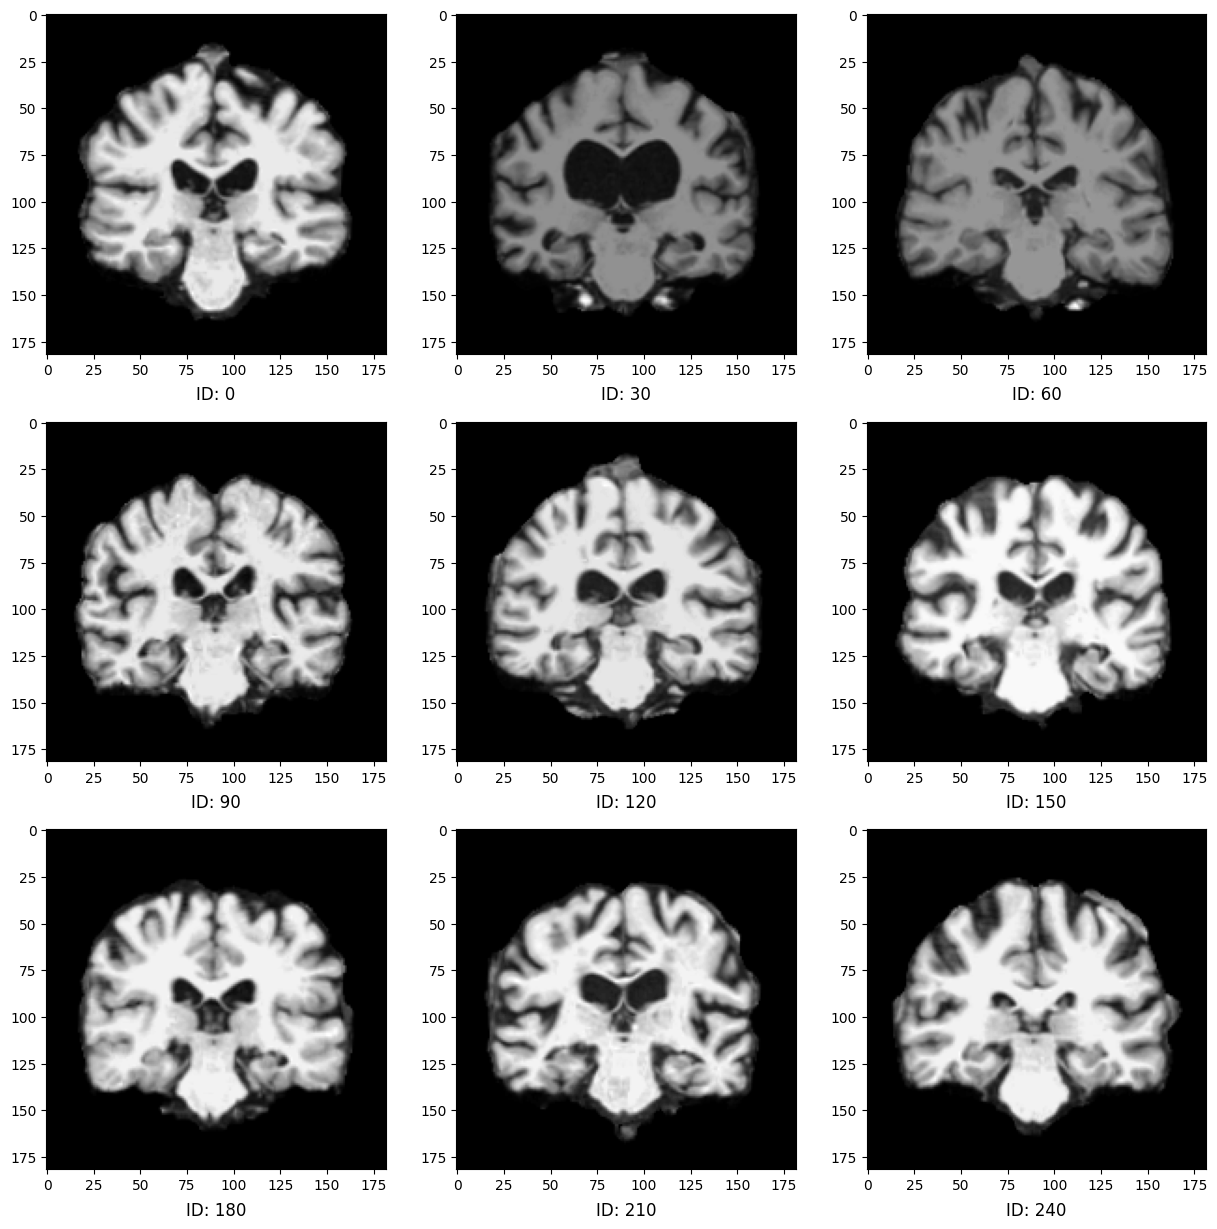

In [27]:
# 再画个图看看
train_dataset.plotall()

#### 2.5.8 构造dataloader

In [28]:
# 先整体测试一下效果
print('预处理前的训练数据：')
print(x_train.shape,x_train.dtype)
print('预处后的训练数据：')
train_dataset.data = train_dataset.data.astype(np.float32)/255
test_dataset.data = test_dataset.data.astype(np.float32)/255
print(train_dataset.data.shape,train_dataset.data.dtype)
print('训练集标签数：'+str(len(train_dataset.label)))

print('预处理前的测试数据：')
print(x_test.shape,x_test.dtype)
print('预处后的测试数据：')
print(test_dataset.data.shape,test_dataset.data.dtype)
print('测试集标签数：'+str(len(test_dataset.label)))

# 数据提取功能测试
img,target = train_dataset[0]
print(img.shape)
print(target)

预处理前的训练数据：
(336, 1, 182, 218, 182) uint8
预处后的训练数据：
(336, 1, 182, 218, 182) float32
训练集标签数：336
预处理前的测试数据：
(85, 1, 182, 218, 182) uint8
预处后的测试数据：
(85, 1, 182, 218, 182) float32
测试集标签数：85
(1, 182, 218, 182)
tensor(0)


In [29]:
# 创建dataloader
BATCH_SIZE = 16

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE)
testDataLoader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE)

In [30]:
# 之前的训练参数
net = RESNet_3d
learning_rate = 0.0001
# momentum = 0.5
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 3e-4)  # adam优化器
#animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], # 监视器就是画图用的
#                            legend=['train loss', 'train acc', 'test acc'])
EPOCH = 50
#device = try_gpu()

## PART2：3D-ResNet转化为SNN实验


In [31]:
import sys
sys.path.append('../../..')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import time
from braincog.utils import setup_seed
from braincog.datasets.datasets import get_cifar10_data
import os
import torchvision
import matplotlib
matplotlib.use('agg')
from tqdm import tqdm
from copy import deepcopy
from braincog.utils import setup_seed
import argparse
import types
from braincog.base.conversion import Convertor
DATA_DIR = '/data/huangxiang/国科大作业/Braincog/data'

/data/huangxiang/anaconda3/envs/pytorch/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/data/huangxiang/anaconda3/envs/pytorch/lib/python3.8/site-packages/braincog/model_zoo/resnet.py:461: UserWarning: Overwriting resnet18 in registry with braincog.model_zoo.resnet.resnet18. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def resnet18(pretrained=False, **kwargs):
/data/huangxiang/anaconda3/envs/pytorch/lib/python3.8/site-packages/braincog/model_zoo/resnet.py:474: UserWarning: Overwriting resnet34 in registry with braincog.model_zoo.resnet.resnet34. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def resnet34(pretrained=False, **kwargs):
/data

#### 3.1 网络分析函数架构

In [32]:
def evaluate_snn(test_iter, snn, device=None, duration=50):
    accs = []
    snn.eval()

    for ind, (test_x, test_y) in tqdm(enumerate(test_iter)):
        #test_x = test_x.type(torch.FloatTensor) /255
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        n = test_y.shape[0]
        out = 0
        with torch.no_grad():
            snn.reset()
            acc = []
            # for t in tqdm(range(duration)):
            for t in range(duration):
                out += snn(test_x)
                print(out)
                result = torch.max(out, 1).indices
                result = result.to(device)
                acc_sum = (result == test_y).float().sum().item()
                acc.append(acc_sum / n)

        accs.append(np.array(acc))
    accs = np.array(accs).mean(axis=0)

    i, show_step = 1, []
    while 2 ** i <= duration:
        show_step.append(2 ** i - 1)
        i = i + 1

    for iii in show_step:
        print("timestep", str(iii).zfill(3) + ':', accs[iii])
    print("best acc: ", max(accs))

In [33]:
# 传统ANN的性能测试函数
def net_test(epoch,net):
    correct = 0
    total = 0
    testing_loss = 0
    with torch.no_grad():  # 测试集不用算梯度

        TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
        TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
        FP = 0.0  # 假阳性样本数
        FN = 0.0  # 假阴性样本数

        for batch_idx, data in enumerate(testDataLoader, 0):
            images, labels = data
            print(images.max(),images.min())
            #images = images.type(torch.FloatTensor) #/255
            images = images.cuda()
            labels = labels.cuda()
            #net.reset()
            outputs = net(images)
            #print(outputs.data)
            loss = criterion(outputs, labels)
            testing_loss += loss.item() * labels.shape[0]
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            #print(total)
            correct += (predicted == labels).sum().item()
            TP += ((predicted == labels)&(predicted == 1)).sum().item()
            TN += ((predicted == labels)&(predicted == 0)).sum().item()
            FP += ((predicted != labels)&(predicted == 1)).sum().item()
            FN += ((predicted != labels)&(predicted == 0)).sum().item()
        ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
        print(ACC)
        SEN = (TP)/(TP+FN)           # 敏感性(Sensitivity)，正例的正确率
        SPC = (TN)/(TN+FP)           # 特异性(Specificity)，反例的正确率
        if (TP+FP) == 0:
            PRC = 0   # 如果全预测为0去了，该指标为0(最差)
        else:
            PRC = (TP)/(TP+FP)       # 查准率(Precision)，预测为1的样本实际为1的概率
        RCA = (TP)/(TP+FN)           # 查全率(Recall)，实际为1的样本中预测为1的概率
        acc = correct / total
        print('[epoch %d/%d]: Accuracy on test set: %.1f %%, LOSS: %.3f,      SEN: %.2f %%, SPC: %.2f %%, PRC: %.2f %%, RCA: %.2f %%' 
              % (epoch+1, EPOCH, 100 * ACC,testing_loss/total, 100 * SEN, 100 * SPC, 100 * PRC, 100 * RCA))  # 求测试的准确率，正确数/总数
    return testing_loss/total,ACC,SEN,SPC,PRC,RCA

In [34]:
batch_n = 0
for batch_idx, data in enumerate(trainDataLoader, 0):
    batch_n += 1
    #print(batch_idx)
print(batch_n)
batch_n = 0
for batch_idx, data in enumerate(testDataLoader, 0):
    batch_n += 1
    #print(batch_idx)
print(batch_n)

21
6


In [35]:
setup_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
net = VGGNet_3D
model_pth = '/data/huangxiang/国科大作业/Braincog/ADdiag/model/3D-VGGNet.pth'
#net = RESNet_3d
#model_pth = '/data/huangxiang/国科大作业/Braincog/ADdiag/model/3D-ResNet.pth'
net.load_state_dict(torch.load(model_pth, map_location=device))
net.eval()
net = net.to(device)
loss_test, acc_test, sen_test,spc_test,prc_test,rec_test= net_test(1,net)    
print(acc_test)

tensor(0.9255) tensor(0.)
tensor(0.9373) tensor(0.)
tensor(0.8745) tensor(0.)
tensor(0.8431) tensor(0.)
tensor(0.9373) tensor(0.)
tensor(0.8000) tensor(0.)
0.8117647058823529
[epoch 2/50]: Accuracy on test set: 81.2 %, LOSS: 0.542,      SEN: 67.74 %, SPC: 88.89 %, PRC: 77.78 %, RCA: 67.74 %
0.8117647058823529


### 将三维VGG-Net转换成特征提取器和分类器

In [36]:

VGGNet_half = nn.Sequential(*list(net.children())[0:28])  
MLP_half = nn.Sequential(*list(net.children())[28:])  
x_printnet = torch.randn(1, 1, 182, 218, 182).to(device)
print('-'*10)
for layer in net:
    x_printnet = layer(x_printnet)
    print(layer.__class__.__name__, 'Output shape:\t', x_printnet.shape)
print('-'*10)
x_printnet = torch.randn(1, 1, 182, 218, 182).to(device)
for layer in VGGNet_half:
    x_printnet = layer(x_printnet)
    print(layer.__class__.__name__, 'Output shape:\t', x_printnet.shape)
print('-'*10)
x_printnet = torch.randn(1,512).to(device)
for layer in MLP_half:
    x_printnet = layer(x_printnet)
    print(layer.__class__.__name__, 'Output shape:\t', x_printnet.shape)

----------
Conv3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
BatchNorm3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
ReLU Output shape:	 torch.Size([1, 32, 58, 70, 58])
Conv3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
BatchNorm3d Output shape:	 torch.Size([1, 32, 58, 70, 58])
ReLU Output shape:	 torch.Size([1, 32, 58, 70, 58])
MaxPool3d Output shape:	 torch.Size([1, 32, 29, 35, 29])
Conv3d Output shape:	 torch.Size([1, 64, 27, 33, 27])
BatchNorm3d Output shape:	 torch.Size([1, 64, 27, 33, 27])
ReLU Output shape:	 torch.Size([1, 64, 27, 33, 27])
Conv3d Output shape:	 torch.Size([1, 64, 25, 31, 25])
BatchNorm3d Output shape:	 torch.Size([1, 64, 25, 31, 25])
ReLU Output shape:	 torch.Size([1, 64, 25, 31, 25])
MaxPool3d Output shape:	 torch.Size([1, 64, 12, 15, 12])
Conv3d Output shape:	 torch.Size([1, 128, 10, 13, 10])
BatchNorm3d Output shape:	 torch.Size([1, 128, 10, 13, 10])
ReLU Output shape:	 torch.Size([1, 128, 10, 13, 10])
Conv3d Output shape:	 torch.Size([1, 128, 8, 11

In [37]:
# 网络重新复合
class rebuild(nn.Module):  
    def __init__(self, net1, net2):   
        # 输入两个前端网络，分别为RESNet_3D和MLP
        super().__init__()
        self.block1 = net1
        self.block2 = net2

    def forward(self, X1, X2):
        # X1和X2分别代表MRI图像和Metadata
        Y1_out = self.block1(X1)
        Y = self.block2(Y1_out)
        return Y

In [38]:
# 测试一下重新组合性能会不会改变
net_rebuild = rebuild(VGGNet_half,MLP_half)
net_rebuild = net.to(device)
loss_test, acc_test, sen_test,spc_test,prc_test,rec_test= net_test(1,net_rebuild)    
print(acc_test)

tensor(0.9255) tensor(0.)
tensor(0.9373) tensor(0.)
tensor(0.8745) tensor(0.)
tensor(0.8431) tensor(0.)
tensor(0.9373) tensor(0.)
tensor(0.8000) tensor(0.)
0.8117647058823529
[epoch 2/50]: Accuracy on test set: 81.2 %, LOSS: 0.542,      SEN: 67.74 %, SPC: 88.89 %, PRC: 77.78 %, RCA: 67.74 %
0.8117647058823529


### 构造用于分类器转化为脉冲神经网络所需的Dataloader

In [39]:
# 计算训练集被特征提取后的特征，构造MLP转ANN的Dataloader
device1 = torch.device("cpu")
VGGNet_half.to(device1)
data_mlp = []
for batch_idx, data in enumerate(trainDataLoader, 0):
    images, labels = data
    images = images.to(device1)
    # labels = labels.to(device1)
    features = VGGNet_half(images)
    if data_mlp == []:
        data_mlp = features
    else:
        data_mlp = torch.cat((data_mlp,features),0)
    #print(features.shape)
    print(data_mlp.shape)
# 还有测试集
testdata_mlp = []
for batch_idx, data in enumerate(testDataLoader, 0):
    images, labels = data
    images = images.to(device1)
    # labels = labels.to(device1)
    features = VGGNet_half(images)
    if testdata_mlp == []:
        testdata_mlp = features
    else:
        testdata_mlp = torch.cat((testdata_mlp,features),0)
    #print(features.shape)
    print(testdata_mlp.shape)

torch.Size([16, 512])
torch.Size([32, 512])
torch.Size([48, 512])
torch.Size([64, 512])
torch.Size([80, 512])
torch.Size([96, 512])
torch.Size([112, 512])
torch.Size([128, 512])
torch.Size([144, 512])
torch.Size([160, 512])
torch.Size([176, 512])
torch.Size([192, 512])
torch.Size([208, 512])
torch.Size([224, 512])
torch.Size([240, 512])
torch.Size([256, 512])
torch.Size([272, 512])
torch.Size([288, 512])
torch.Size([304, 512])
torch.Size([320, 512])
torch.Size([336, 512])
torch.Size([16, 512])
torch.Size([32, 512])
torch.Size([48, 512])
torch.Size([64, 512])
torch.Size([80, 512])
torch.Size([85, 512])


In [40]:
# 创建dataloader
BATCH_SIZE = 16
#print(data_mlp)
#构建数据集和测试集的DataLoader
# 测试集数据直接构造即可
class MyDataset_mlp(Dataset):
    def __init__(self, x,y):
        self.data = x
        self.label = y

    def __getitem__(self, index):
        img = self.data[index]
        img_label = self.label[index]
        return img, img_label
    
    def __len__(self):
        return len(self.label)

train_dataset_mlp = MyDataset_mlp(data_mlp.detach().numpy(),train_dataset.label)
trainDataLoader_MLP = torch.utils.data.DataLoader(dataset = train_dataset_mlp,batch_size = BATCH_SIZE)
test_dataset_mlp = MyDataset_mlp(testdata_mlp.detach().numpy(),test_dataset.label)
testDataLoader_MLP = torch.utils.data.DataLoader(dataset = test_dataset_mlp,batch_size = BATCH_SIZE)

In [41]:
# 测试一下数据集确实可用
TP = 0.0  # 真阳性样本数，TF表示预测正确情况，T表示预测正确(True)，F表示预测错误(False)
TN = 0.0  # 真阴性样本数，PN表示预测值，P表示预测为1，N表示预测为0
FP = 0.0  # 假阳性样本数
FN = 0.0  # 假阴性样本数
total = 0
correct = 0
for batch_idx, data in enumerate(trainDataLoader_MLP, 0):
    images, labels = data
    print(images.max(),images.min())
    #images = images.type(torch.FloatTensor) #/255
    print(images.shape)
    images = images.cuda()
    labels = labels.cuda()
    #net.reset()
    outputs = MLP_half(images)
    #print(outputs.data)
    #loss = criterion(outputs, labels)
    #testing_loss += loss.item() * labels.shape[0]
    _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
    print(predicted)
    print(labels)
    total += labels.size(0)  # 张量之间的比较运算
    #print(total)
    correct += (predicted == labels).sum().item()
    TP += ((predicted == labels)&(predicted == 1)).sum().item()
    TN += ((predicted == labels)&(predicted == 0)).sum().item()
    FP += ((predicted != labels)&(predicted == 1)).sum().item()
    FN += ((predicted != labels)&(predicted == 0)).sum().item()
    ACC = (TP+TN)/(TP+TN+FP+FN)  # 准确率
    print(ACC)

tensor(3.7500) tensor(0.)
torch.Size([16, 512])
tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
1.0
tensor(4.0666) tensor(0.)
torch.Size([16, 512])
tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
1.0
tensor(3.6526) tensor(0.)
torch.Size([16, 512])
tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
1.0
tensor(3.3742) tensor(0.)
torch.Size([16, 512])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
1.0
tensor(4.3867) tensor(0.)
torch.Size([16, 512])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
1.0


#### 将MLP转化为SNN并测试模型性能

In [42]:
converter = Convertor(dataloader=trainDataLoader_MLP,
                        device=device,
                        p=1,
                        channelnorm=False,
                        lipool=True,
                        gamma=1,
                        soft_mode=True,
                        merge=True,
                        batch_num=1,
                        spicalib=0,
                        )
mlp_snn = converter(MLP_half)

In [43]:
def evaluate_snn(test_iter, snn, device=None, duration=50):
    accs = []
    snn.eval()

    for ind, (test_x, test_y) in tqdm(enumerate(test_iter)):
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        n = test_y.shape[0]
        out = 0
        with torch.no_grad():
            snn.reset()
            acc = []
            # for t in tqdm(range(duration)):
            for t in range(duration):
                out += snn(test_x)
                result = torch.max(out, 1).indices
                result = result.to(device)
                acc_sum = (result == test_y).float().sum().item()
                acc.append(acc_sum / n)

        accs.append(np.array(acc))
    accs = np.array(accs).mean(axis=0)

    i, show_step = 1, []
    while 2 ** i <= duration:
        show_step.append(2 ** i - 1)
        i = i + 1

    for iii in show_step:
        print("timestep", str(iii).zfill(3) + ':', accs[iii])
    print("best acc: ", max(accs))

In [44]:
#loss_test, acc_test, sen_test,spc_test,prc_test,rec_test= net_test(1,snn)    
#print(acc_test)
evaluate_snn(testDataLoader_MLP, mlp_snn, device, duration=50)

6it [00:00, 29.23it/s]

timestep 001: 0.84375
timestep 003: 0.8333333333333334
timestep 007: 0.8333333333333334
timestep 015: 0.8333333333333334
timestep 031: 0.8333333333333334
best acc:  0.84375


In [45]:
# 重新拼接脉冲神经网络
snn_net = rebuild(VGGNet_half,mlp_snn)
net_rebuild = net.to(device)

In [46]:
evaluate_snn(testDataLoader_MLP, mlp_snn, device, duration=50)

6it [00:00, 34.41it/s]

timestep 001: 0.84375
timestep 003: 0.8333333333333334
timestep 007: 0.8333333333333334
timestep 015: 0.8333333333333334
timestep 031: 0.8333333333333334
best acc:  0.84375
